<a href="https://colab.research.google.com/github/Jingxuan99/-Python-2-/blob/master/%EF%BC%88%E6%9C%80%E7%BB%88%E7%89%88%E6%9C%AC%EF%BC%89project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Python - Project 1

Due Friday, March 18th by 5 pm.

Jingxuan Liu (s2171354), Wenhui Ni (s2202722), Yuan Yao (s2259521)

## 0. Setup

In [ ]:
!pip install feature_engine

In [ ]:
# Data libraries
import pandas as pd
import numpy as np
import scipy

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

# Import tools for spelling check
from itertools import combinations
from difflib import SequenceMatcher

# Hide warning messages
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('error', UserWarning)

# feature_engine modules
from feature_engine.selection import DropCorrelatedFeatures

# imblearn modules
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline

# pandas modules
from pandas.api.types import is_string_dtype

In [ ]:
def check_spelling(series_data):
  '''
  To check possible spelling error.

  Input: A series data from a DataFrame, contains strings
  Output: A DataFrame which suggest possible spelling error
  '''
  # Combine all names in pairs
  all_pairs = list(combinations(np.sort(series_data.unique()), 2)) 
  similar_pairs = pd.DataFrame(columns=['Pairs', 'Similarity'])
  for pairs in all_pairs:
    # Compute the similarity
    similarity_value = SequenceMatcher(None, pairs[0], pairs[1]).ratio() 

    # Judgement condition: very high similarity (spelling error) OR 
    # splitting out all characters to be consistent (order problem)
    if similarity_value>=0.9 or sorted(pairs[0])==sorted(pairs[1]):
      similar_pairs = similar_pairs.append({'Pairs':pairs, 
                                            'Similarity':similarity_value}, 
                                           ignore_index=True)
  return similar_pairs

def drop_na(X, y, axis=0):
  '''
  Remove the empty values in the dataset

  Input: The datasets that need to check and remove NA
  Output: The two corresponding datasets without NA
  '''
  # Merge the two datasets and remove NA together
  df = pd.concat([X,y], axis=1)
  df = df.dropna(axis=axis)
  return df.iloc[:,:-1], df.iloc[:,-1]
  

def text_split(df, sep):
  '''
  To split strings of a feature.

  Input:
    df: A df containing strings that to be splited
    sep: The separator used to split text
  Output: A string that has been splited by the specified separator
  '''
  for col in df.columns:
    # Split the strings and stack them together
    df_splited = df[col].str.split(sep, expand=True).stack()
    # Convert the splited values to a string separated by an empty space
    df[col] = df_splited.unstack()[0].str.cat(
        [df_splited.unstack()[k] for k in range(
            1, len(df_splited.unstack().columns))], sep=' ', na_rep='')
  return df

def TF_IDF_encoding(df):
  '''
  To encode categorical features by TF-IDF algorithm

  Input: The feature that need to be encoded 
  Output: A dataframe with encoded features
  '''
  # Define TF-IDF encoder 
  tf_idf_vec = TfidfVectorizer(use_idf=True, smooth_idf=True, 
                               ngram_range=(1,1), stop_words='english')
  df_ = pd.DataFrame()

  for col in df.columns:
    # Fit and transform to encode the categorical features
    tf_idf_data = tf_idf_vec.fit_transform(df[col])
    # Create a dataframe with encoded values
    tf_idf_df = pd.DataFrame(tf_idf_data.toarray(), 
                             columns=tf_idf_vec.get_feature_names())
    df_ = pd.concat([df_, tf_idf_df], axis=1)
  return df_ 

def main_people_plot(df, relevant_values, sep=';', threshold=0.5, boxplot=False):
  '''
  Select the main data based on threshold. 
  Draw boxplots of their corresponding values if required.

  Input: 
    df: DataFrame of string values (name of people)
    relevant_values: Numerical values correspond to df, values used to plot
    boxplot: boolean value, indicate whether to plot or not
    sep: seperator
    threshold: level of selection

  Output: The list(s) of main persons' name
  '''
  # Create empty arrays to hold the filtered data
  groups_dic = []
  group_lowerbounds = []
  group_names = []

  # Loop over groups to sort
  for col in df.columns:
    # Split the names in the group and sort these names 
    # by the number of times they have appeared
    names_count = df[col].str.split(pat=sep, expand=True).stack().value_counts()
    # Get a lowerbound for filtering
    count_lowerbound = int(names_count.max()*threshold)
    # Get the main names
    main_names = names_count[names_count>=count_lowerbound].index.values
    # Store the filtered names and corresponding ratings in the dictionary
    main_names_dict = {}
    for name in main_names:
      main_names_dict[name] = relevant_values[df[col].str.contains(name)]
    # Put the filtered data into an array
    groups_dic.append(main_names_dict)
    group_names.append(list(main_names_dict.keys()))
    group_lowerbounds.append(count_lowerbound)

  # Plot boxplots if needed 
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if boxplot:
      n_col = df.shape[1] # Get how many columns
      fig, axs = plt.subplots(1, n_col, figsize=(18,5))
      for col in range(n_col):
        col_name = df.columns[col]
        axs[col].boxplot(groups_dic[col].values(), showmeans=True)
        axs[col].set_xticklabels(group_names[col], rotation=-30, ha="left")
        axs[col].set_ylabel('Ratings')
        axs[col].set_title('Main ' + col_name + ' and ratings')
        axs[col].set_xlabel('Main ' + col_name + '(who participated at least ' +
                            f'{group_lowerbounds[col]} episodes')
      plt.suptitle('Fig2. Main anticipators and ratings', fontsize=20)
      plt.show()
  return main_names

def select_people(df, namelist):
  '''
  Select the main data based on threshold. 
  Draw boxplots of their corresponding values if required.

  Input: 
      df: DataFrame of string values (name of people)
      sep: seperator
      threshold: level of selection
  Output: The list(s) of main persons' name
  '''
  df_ = df.copy()
  # Remove people whose appearance ratio is higher than the threshold
  for col in df_.columns:
    if is_string_dtype(df_[col]):
      for substring in namelist:
        df_[col] = df_[col].str.replace(substring, '')
  return df_

def DfTransformer(X, column_names = None):
  '''
  Convert X to a pandas dataframe 

  Input: A matrix that need to be converted to a dataframe
  Output: The converted dataframe 
  '''
  X_ = X.copy() 

  # Turn to a pandas df if a numpy array
  if isinstance(X_, (np.ndarray, np.generic)):
      X_ = pd.DataFrame(X_, columns=column_names)
  # Turn to a pandas df if sparse
  elif scipy.sparse.issparse(X_):
      X_ = pd.DataFrame.sparse.from_spmatrix(X_, columns=column_names)
  # Change the column names if provided and not the same
  elif isinstance(X_, pd.DataFrame):
      if not column_names==None and set(list(X_.columns)) == set(column_names):
          X_.columns = column_names
  else:
      warnings.warn("""{} not a supported input. Input needs to be in:
      [np.ndarray, np.generic, scipy.sparse, pd.DataFrame]""".format(type(X_)))
  return X_

def create_features(X, n_words, n_speak_char):
  '''
  Create a more meaningful feature: number of words per character speak
  
  Input:
    X: The dataset that contains 
    n_words: A feature that needs to be combinded with others
    n_speak_char: A feature that needs to be combinded with others
  Output:
    The dataset with created new features
  '''
  X_ = X.copy()

  # Combine the two features to creae a new one
  X_['words_per_speak'] = X_[n_words] / X_[n_speak_char]
  return X_

def drop_day_outlier(X, y, column_name, day_to_drop):
  '''
  Remove the date that is regarded as an 'outliers' from the dataset

  Input:
    X, y: The datasets may contain the 'outliers'
    column_name: The column that contains the 'outliers'
    day_to_drop: the day regared as an 'outlier'
  Output:
    The two corresponding datasets without 'outliers' of date
  '''
  # Merge X and y, and remove the day 'outliers' together
  df = pd.concat([X, y], axis=1)
  df = df[df[column_name] != day_to_drop]
  return df.iloc[:,:-1], df.iloc[:,-1]

def drop_duplicated(X, y):
  '''
  Remove the duplicated values from X and y together

  Input: The two related datasets may contain the duplicated values
  Output: The two corresponding datasets without duplicated values
  '''
  # Merge X and y, and remove the duplicated values together
  df = pd.concat([X,y], axis=1)
  df = df.drop_duplicates()
  return df.iloc[:,:-1], df.iloc[:,-1]

def change_datetime(column):
  '''
  Convert the string of time to the day of a week

  Input: The column of datetime
  Output: The column of the day of week
  '''
  # Convert the date to the day of week. 
  # Representatinon from Monday to Sunday is 0-6
  return pd.to_datetime(column).dt.weekday

def change_names(df):
  '''
  Change the wrong names in the DataFrame

  Input: DataFrame with wrong spellings of known directors/writers
  Output: DataFrame with correct spellings of known directors/writers
  '''
  # Dictionaries correspond to wrong and correct names of directors/writers
  wrong_name = {'directors':['Charles McDougal','Claire Scanlong',
                             'Lee Eisenberg;Gene Stupnitsky','Greg Daneils',
                             'Ken Wittingham','Paul Lieerstein'],
                'writers':['Lee Eisenberg;Gene Stupnitsky',
                           'Warren Lieberstein;Halsted Sullivan',
                           'Lee Eisenberg;Gene Stupnitsky;Michael Schur',
                           'Michael Schur;Lee Eisenberg;Gene Stupnitsky']}
  
  correct_name = {'directors':['Charles McDougall', 'Claire Scanlon', 
                               'Gene Stupnitsky;Lee Eisenberg', 'Greg Daniels', 
                               'Ken Whittingham','Paul Lieberstein'], 
                  'writers':['Gene Stupnitsky;Lee Eisenberg', 
                             'Halsted Sullivan;Warren Lieberstein', 
                             'Gene Stupnitsky;Lee Eisenberg;Michael Schur', 
                             'Gene Stupnitsky;Lee Eisenberg;Michael Schur']}

  # Select text like columns in df
  textlike_columns = df.select_dtypes(include=[object, "string"]).columns
  
  # Loop to change name
  for column_name in textlike_columns:
    if column_name in wrong_name.keys():
      df[column_name].apply(lambda x: pd.replace(x,
                 correct_name[column_name](wrong_name[column_name].index(x)),
                 inplace=True) if x in wrong_name[column_name] else 'pass')
  return df

def get_coefs(m):
    '''
    Obtain the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.

    Input: A sklearn model object
    Output: The intercept and the coefficients of the fitted model as an array.
    '''
    # If in pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    if m.intercept_ is None:
        return m.coef_
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, num=1, name='model', plot = False):
  '''
  Obtain the root mean squared error from a Scikit-learn model object 
  provided X and y values.
  
  Input:
    m: sklearn model object
    X: model matrix to use for prediction
    y: outcome vector to use to calculating rmse and residuals
    num: the index of figure
    name: model name
    plot: boolean value, should fit plots be shown 
  Output: The value of rmse for the given model
  '''
  # Predictive values
  y_hat = m.predict(X)
  # Compute the residuals
  res = pd.DataFrame(data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat})
  
  if plot:
    # Plot the prediction values against true values
    sns.lineplot(x='y', y='y_hat', color="grey", 
                  data=pd.DataFrame(data={'y': [min(y), max(y)], 
                                          'y_hat': [min(y), max(y)]}))
    sns.scatterplot(x='y', y='y_hat', data=res).set_title(
        f"Fig{num}. Fit Plot for Test Set \n under {name}", fontsize=15)
    plt.xlabel("y's true vlue", fontsize=13)
    plt.ylabel("y's prediction value", fontsize=13)
    plt.show()
  return 

def extract_columns(df, features):
  '''
  To extract some columns from dataframe.

  Input: 
    df: A initial DataFrame 
    features: A list of feature names which we want 
  Output: A new DataFrame generated with the featurs we want
  '''
  df_ = df.copy()
  df_ = df[features]
  return df_

In [ ]:
# Access files in the Google drive
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/project1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
d = pd.read_csv("the_office.csv")

## 1. Introduction

In an increasingly technological society, the success of a television show requires a vast multi-variable formula. Success is not just something that happens, which also requires a great deal of study and application. This project aims to analyse and simulate data from the last nine seasons of the classic television show *The Office* to establish a decision support model that can show reasonable and predictable results to support in planning reunion specials and provide constructive advice to NBC Universal.

The dataset used for this project contains data on the ratings, number of votes, episode titles, names of the relevant directors and writers, names of the main characters and lines for *The Office* from its first season in March 2005 to the ninth season finale in May 2013. The ratings are obtained from IMDb, which is an online information database for related films, television series, etc. The ratings received from audience ranging from 1 to 10. We consider these rating data `imdb_rating` as the response variable which reflects the public approval of the show. And the rest of the data are the features that may affect this dependent variable. The predictive model presented in this study uses data to examine and evaluate the factors that contribute to the success of sitcoms. The factors tested for statistical significance on episode ratings were total votes, major characters, directors and writers. These statistics show that while the total number of votes is indeed crucial to the show itself, the main characters have an impact on both the ratings and the success of the show. 

We employ machine learning based predictive models such as linear regression, decision trees and neural networks to predict the success of shows. These models represent a baseline for how producers can improve the success of TV shows and use this data to create future shows, as the variables are statistically significant that they can still optimise and positively influence ratings.

The paper is organised as follows: Section 2 covers the data exploratory analysis and feature engineering, including data preprocessing, categorical feature encoding, feature combination, feature selection and feature scaling. In Section 3, we choose $R^2$ score and root mean square error (RMSE) to evaluate model performance, aiming to fit and tune the model to obtain a better one. Next, we combine our data processing procedures in Section 2 and applicable models into one pipeline, ultimately we decide to go with the multiple linear regression model for further validation, evaluation and prediction. Section 4 briefly concludes the report and provides our concrete recommendations to NBC Universal.

## 2. Exploratory Data Analysis and Feature Engineering

First of all, we split our data into training and test sets to avoid focusing on specific patterns in data which may lead us to build models that do not work well on new data and thus to ensure generalisability of our model. The original downloaded data is sorted by original air date of episode, to prevent data ordering affecting our model, shuffle is required before spliting data into two sets. One season can be regarded as a unit for TV shows as the planning of each season of the TV series is relatively independent. For example, each season may have a central theme, which leads to the rating of episode in a season may have similarity. Here we thus apply stratified splitting that the data is divided into homogeneous subgroups of in terms of seasons to ensure that the proportion of each season is similar in the test set to the training set.

In [ ]:
# Copy the original dataset
d_copy = d.copy()

# Creating train and test set, and  feature matrix and response varible 
train_set, test_set = train_test_split(d_copy, train_size=0.8,
                                       stratify = d[['season']], 
                                       shuffle=True, random_state=42)
y_train = train_set.loc[:,'imdb_rating']
X_train = train_set.drop('imdb_rating', axis=1)
y_test = test_set.loc[:,'imdb_rating']
X_test = test_set.drop('imdb_rating', axis=1)

# Copy the train set
explore_set = train_set.copy()

### 2.1 Exploratory Data Analysis

Let us start by looking briefly at the basic information about our dataframe. From this concise summary of our DataFrame, we could see that there are 13 columns and 186 entries. Most of the data are numerical values and 5 columns are strings including names of directors, writers, characters, and names and dates of episodes. Apart from that, there is no null values in our dataset.

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


As the histogram shows, we can see that the distribution of the IMDb ratings is approximately normal. The data is distributed between 6.5 and 9.7, with the majority concentrated around a range of 7.8 to 8.7.

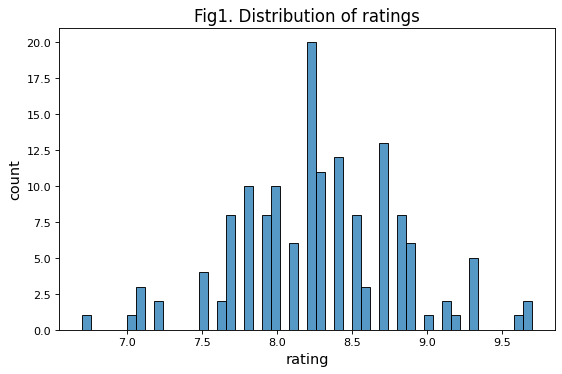

In [ ]:
# Distribution of ratings
sns.histplot(x=explore_set['imdb_rating'], bins=50, palette='Paired')
plt.title('Fig1. Distribution of ratings', fontsize=15)
plt.xlabel('rating',fontsize=13)
plt.ylabel('count',fontsize=13)
plt.show()

After looking at the dataset in detail, we found a couple of spelling errors in the names of directors and writers, as well as issues with the order in which multiple names appear simultaneously. We therefore wrote a function `check_spelling` to check and `change_names` to solve this problem.

In [ ]:
# Check wrong names in the dataset
check_spelling(X_train.director
               ).append(check_spelling(X_train.writer)
               ).reset_index(drop=True)

,Pairs,Similarity
0,"(Charles McDougal, Charles McDougall)",0.969697
1,"(Claire Scanlon, Claire Scanlong)",0.965517
2,"(Gene Stupnitsky;Lee Eisenberg, Lee Eisenberg;...",0.517241
3,"(Paul Lieberstein, Paul Lieerstein)",0.967742
4,"(Gene Stupnitsky;Lee Eisenberg, Lee Eisenberg;...",0.517241
5,"(Halsted Sullivan;Warren Lieberstein, Warren L...",0.514286


In [ ]:
# Revise the wrong names
X_train = change_names(X_train)

The following three boxplots show the distributions of ratings of main directors, main writers and main characters. Because there are too many people involved in the past 9 seasons, so we define the "main" term based on the number of episodes they participated in to choose part of them to analyse in the boxplot. The threshold is set to be 0.5, which means we select directors, writers and characters with the top 50% of participation. In the three boxplots, the orange line segments correspond to the median and the small green arrows correspond to the mean value. For the first plot, we could see that the ratings varies between directors. Greg Daniels, Paul Feig, Ken Whittingham and Jeffrey Blitz have the highest median ratings at around 8.4 and Paul Feig has the highest mean rating of 8.6. The second plot is the distribution of ratings of main writers, their mean values are approximatly of 8.4 and Paul Lieberstein have the highest meadian value at 8.5. While there are not much differences among the main characters, only Kelly and Michael have the highest average rating around 8.3.

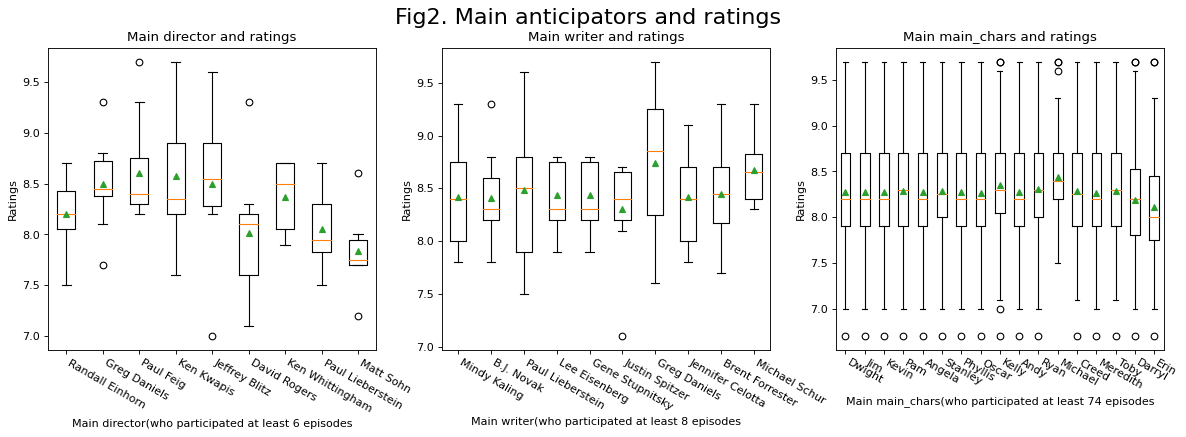

In [ ]:
# Visualize top ratings in terms of director, writer, main characters
main_people_plot(explore_set[['director', 'writer', 'main_chars']], 
                 explore_set['imdb_rating'], boxplot=True);

We noticed that there are many directors and writers leading the series of *The Office*, amounting to 186 episodes. As the pictures above show, only 9 directors participated more than six episodes and only ten writers participated more than 8 episodes. In this case, we do not have enough information to analyse contributions of each director or writer for ratings. By the contrary, there are 17 main characters listed in the data. And there are eight characters, including Dwight, Jim, Pam, Kevin, Angela, Phyllis, Stanldy and Oscar, who appeared over 85% of episodes. Those who participated nearly all episodes can be regarded as resident actors, mathematically, as constants. Thus for serial dramas, the resident actors have become a sentiment which is difficult to quantify and predict their impact. We will not consider these characters in our final design matrix used in the model afterwards in Section 2 & 3.

For features in our later design matrix, `season`, `episode`, and `episode_name` will not be included as well. Since episode and season number were straightforward and we have shuffled and reorderd our dataset to split in train and test sets, there should be little to no relationship between episode and season numbers of the show. Similar for episode titles, its specificity and variability can create large number variables in text analysis which results in sparsity in the design matrix, even though the titles may closely follow the content of episode. However, due to the abstraction and refinement of episode names, we cannot obtain enough information from titles in relation to the rating to analyse their relevance and use them for further prediction.

In [ ]:
director_num = d['director'].str.split(';', expand=True).stack().nunique()
writer_num = d['writer'].str.split(';', expand=True).stack().nunique()
mainchar_num = d['main_chars'].str.split(';', expand=True).stack().nunique()
print(f'There are totally {director_num} directors.')
print(f'There are totally {writer_num} writers.')
print(f'There are totally {mainchar_num} main characters listed in the data.')

There are totally 60 directors.
There are totally 40 writers.
There are totally 17 main characters listed in the data.


In [ ]:
# Find main characters who are involved in more than 85% episodes
main_names = main_people_plot(d_copy[['main_chars']], 
                              d_copy['imdb_rating'], threshold=0.85)
print('Main characters who appeared in over 85% episodes:' +
      f'\n{", ".join(main_names)}')

Main characters who appeared in over 85% episodes:
Dwight, Jim, Pam, Kevin, Angela, Phyllis, Stanley, Oscar


In [ ]:
# The data used to model
X_train = X_train.iloc[:, 5:]
X_test = X_test.iloc[:, 5:]

Here we have a general look at correlated features by the following heatmap. We find that the number of ratings for episode on IMDb (total_votes) has the highest correlation (around 0.65) with episode rating on IMDb (imdb_rating) in comparison with other features. By the contrary, airing date has little correlation and season number is even negatively correlated with ratings. This possibly implies that we need to focus on how to address these features with combination with their actual applications before fitting our model. 

Moreover, this heatmap also prepares for later selecting features (i.e. dropping features that are highly correlated with another feature). For example, a particularly strong positive correlation (> 0.9) exists between number of dialog words in episode (n_words) and number of spoken lines in episode (n_lines), while these two features both have similar correlation with our response feature (imdb_rating).

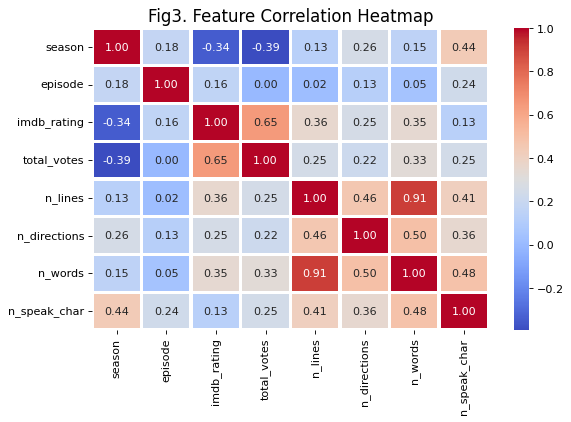

In [ ]:
# Correlations bwteen two features
sns.heatmap(explore_set.corr(), annot=True, fmt='.2f', 
            linewidths=2, cmap='coolwarm')
plt.title("Fig3. Feature Correlation Heatmap", fontsize=15)
plt.show()

As Fig.4 indicates, we can see a general trend of a moderately decreasing number of votes, with most episodes having between 1,500 and 2,000 votes. The middle episode of the fifth season and the final episode of the final season that have aired so far have had two very high peaks of over 5,000 votes, and even the final season finale reached almost 8,000 votes. The number of votes cast is somewhat indicative of the popularity of the episode, with the unusually high number of votes cast for the season 5 episode titled "Stress Relief (Parts 1&2)", which was broadcast after the Super Bowl and received very high ratings so the number of people who voted for it was particularly high.

Most of the episodes have averaged above 8.0, with the season 8 average being below 8.0 and several of the episodes even below 7.0. The rating fluctuated around 8.2 during the first season, and gradually increased as people got used to the show's style over the following seasons. However, in season 6, there was a significant drop in ratings. One possible reason for the drop in season 8 is the departure of a major character, Michael, in season 7. The season 9 finale was very high in terms of both votes and ratings, as it was the end of the show's eight-year run, and the audience rated it with a sense of emotion for the past and anticipation for the new season, so the ratings were very high.

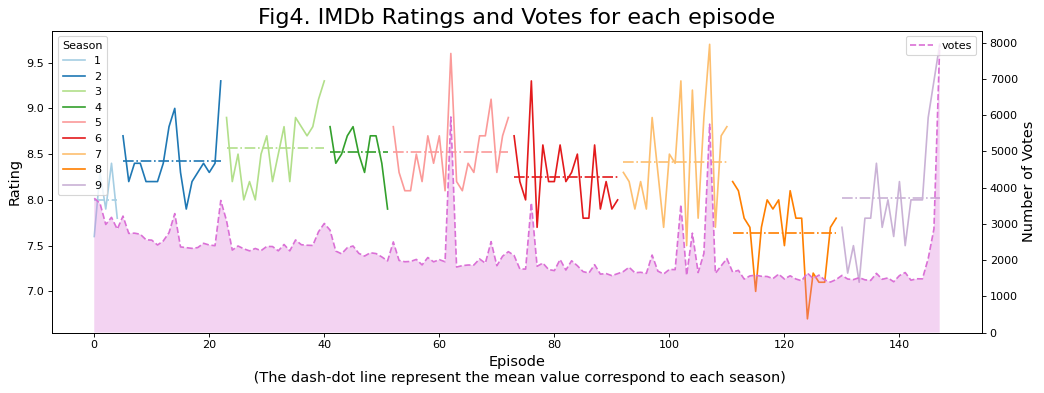

In [ ]:
# Reorder for ploting
d_order = explore_set.sort_values(['season', 'episode'],
                                  ascending=(True, True), ignore_index=True)

# Compute the mean rating values for each season
rate_season = d_order['imdb_rating'].groupby(d_order['season']).mean()

# Plot IMDb ratings and votes for each episode on the same figure
fig, ax1 = plt.subplots(figsize=(15,5))
# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx() 
sns.lineplot(x=d_order.index, y='imdb_rating', data=d_order, 
             hue='season', palette='Paired', ax=ax1)
sns.lineplot(x=d_order.index, y='total_votes', data=d_order, 
             color='orchid', linestyle='dashed', ax=ax2, label='votes')
ax2.stackplot(d_order.index, d_order['total_votes'], 
              colors='orchid', alpha=0.3)

# Add dashed lines to indicate the mean ratings of each season
for season in d_order['season'].unique():
  index_min = d_order[d_order['season']==season].index[0]
  index_max = d_order[d_order['season']==season].index[-1]
  ax1.plot([index_min, index_max], [rate_season[season]]*2, '-.', 
           color=sns.color_palette("Paired")[season-1])
ax1.set_xlabel('Episode\n (The dash-dot line represent' + 
               ' the mean value correspond to each season)', fontsize=13)
ax1.set_ylabel('Rating', fontsize=13)
ax1.legend(title='Season', loc='upper left')
ax1.set_title('Fig4. IMDb Ratings and Votes for each episode', fontsize=20)
ax2.set_ylabel('Number of Votes', fontsize=13)
ax2.legend(loc='upper right')
plt.show()

### 2.2 Data Preprocessing


#### 2.2.1 Date Processing

The TV series had a wide range of air dates, covering a period of eight years, with a very scattered and discontinuous distribution. Because of this, We cannot see any apparent pattern of the ratings with respect to the time series. Therefore, we converted the `air_date` data to datetime object and then extract the day of week information from that date.

After this transformation, we present the evolution of the ratings of the show over the past nine seasons and the corresponding days of the week on the same scatter plot. From the plot below, we can conclude that the show aired initially on Tuesdays (Season 1 and few episodes of Season 2). The series was later switched to its regular Thursday airtime for the rest of the seasons, with the exception of one episode, *Stress Relief*, which aired on Sundays.

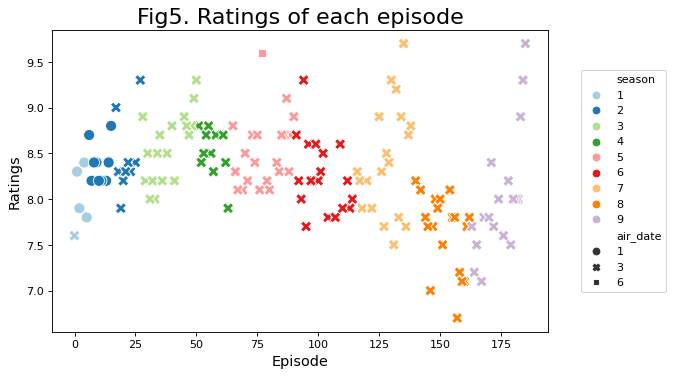

In [ ]:
# Converting air date to datetime object and convert to 
# day of week (1 for Tuesday, 6 for Sunday)
X_train['air_date'] = pd.to_datetime(X_train.air_date).dt.weekday
X_test['air_date'] = pd.to_datetime(X_test.air_date).dt.weekday
d_copy['air_date'] = pd.to_datetime(d_copy.air_date).dt.weekday
explore_set['air_date'] = pd.to_datetime(explore_set.air_date).dt.weekday

# Visualize day of the week
sns.scatterplot(data=explore_set.drop('imdb_rating', axis=1), 
                x=explore_set.drop('imdb_rating', axis=1).index, 
                y=explore_set['imdb_rating'], style='air_date',
                palette='Paired', hue='season', s=100)
plt.xlabel('Episode', fontsize=13)
plt.ylabel('Ratings', fontsize=13)
plt.title('Fig5. Ratings of each episode', fontsize=20)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.show()

As aforementioned, the rating of the special episode aired on Sunday scored particularly high because of the marketing in the broadcast of Super Bowl. Bases on this practical situation and amazing result obtained different from the usual, we consider this episode as an outlier to cover the normal cases as much as possible. More remarkably, the average rating of episodes aired on Tuesdays is higher than that on Thusdays, while the standard deviation of rating on Thusdays is approxite twice that of on Tuesdays. The airing day of the week is likey to be significant for predicting episode rating. Thus, we intend to include this feature by the OneHotEncode method in our model.

In [ ]:
# Describe statistics of episode rating in terms of day of the week
day_sta = d_copy.groupby('air_date', as_index=False
                         ).agg({'imdb_rating': ['mean','std','count']}).round(2)
day_sta.columns = ['Day', 'Mean', 'Std', 'Count']
day_sta.Day = ['Tuesday', 'Thursday', 'Sunday']
day_sta

,Day,Mean,Std,Count
0,Tuesday,8.31,0.27,15
1,Thursday,8.24,0.54,170
2,Sunday,9.60,NaN,1


#### 2.2.2 Anomaly Detection

According our exloration of date previously in Section 2.2.1, we delete the episode aired on Sunday to make sure the following research is based on a common situation. We also noticed some spelling errors in the names of directors and writers, as well as issues with the order in which multiple names appear simultaneously. We handle with these anomaly problems in Section 2.1 to derive a more precise EDA. Here we don't repeat again.

In [ ]:
# Drop the day 'outliers' from the datasets
X_train, y_train = drop_day_outlier(X_train, y_train, 'air_date', 6)
X_test, y_test = drop_day_outlier(X_test, y_test, 'air_date', 6)

# Copy train sets
X_train_ = X_train.copy()
y_train_ = y_train.copy()

#### 2.2.3 Detect Duplications


We intend to remove duplicates in this subsection as they may bias our fitted model. In other words, duplicates may potentially lead to overfitting. Indeed, there is no duplicated rows in our dataset, which is consistent to the fact that *The Office* has total 186 episodes with airing information of each episode saved in each row. For insurance, we still implement dropping of duplicated values.

In [ ]:
# Check how many duplicated rows in df
print(f"{X_train_.duplicated().sum()} duplicated row in our dataframe.")

0 duplicated row in our dataframe.


In [ ]:
# Remove the duplicate rows
X_train_.drop_duplicates(inplace=True)

#### 2.2.4 Remove Unavailable Values


In this subsection, we check and remove missing values. In fact, from the EDA in previous subsection, we have already found that *The Office* dataset has no missing value. Hence there is actually no further addressing we need to consider, such as removing or replacing approaches. For insurance, we still implement the removal of unavailable values.

In [ ]:
# Remove missing values
na_sampler = FunctionSampler(func=drop_na, validate=False) 
X_train_, y_train_ = na_sampler.fit_resample(X_train_, y_train_)

### 2.3 Feature Engineeing


Feature engineering is an essential step of the machine
learning pipeline to improve predictive models. In general, models are capable of finding patterns in data, but none of them are infallible, and certain models are better at finding certain patterns than others. In the following subsection, we will explain in detail and implement by formulating appropriate features and transforming features into formats that are suitable for machine learning models.

#### 2.3.1 Encoding Categorical Variables

Most of data in this dataset (e.g. main characters) is categorical, but the variety of models that can take in non-numeric data is very limited. One of the most popular approachs of converting categorical features to numeric is one-hot-encoding. We apply this simple method to encode weekdays data without creating unwieldy numbers of columns, as this series was previously only updated on Tuesday and Thusday.

As mentioned in Section 2.1, we only study part of main characters' relation with rating because of their broad impact on almost every episode, so we delete those characters gained above. The impact of some main characters on the rating is critical, for example, some episodes like '*Goodbye, Toby (Parts 1&2)*' (S04, E18) and '*Goodbye, Michael*' (S07, E22) have high ratings compared to others as Fig.4 shows. And episodes after that apparently got lower ratings which demonstrate the importance of some characters. Considering that the technique Term Frequency-Inverse Document Frequency (TF-IDF) can denote the significance of the character (i.e. the TF-IDF model contains information on the more important characters and the less important ones as well), we implement this encoding method on another feature, main characters. In this way, we can probably find relationships between the rating and some most important characters. 

In [ ]:
# Encode the weekdays by one-hot-encoding 
date_encode = pd.get_dummies(X_train_['air_date'], 
                             columns='air_date').reset_index(drop=True)
date_encode.columns = ['Tuesday', 'Thursday']      
                       
# Encode the main characters by TF-IDF method
chars_encode = TF_IDF_encoding(text_split(
    select_people(X_train_[['main_chars']], main_names), ';'))

#### 2.3.2 Feature Combination

For the give two features, number of different characters with spoken lines in episode and number of dialog words in episode, we combine them so that we can measure number of dialog words per characters in episode, which is a more general feature to demonstrate the activity level of the episode and the engagement of the characters.

In [ ]:
# Function transformer to create features by combination
FeatureTransformer=FunctionTransformer(create_features, 
                                       kw_args={'n_words': 'n_words', 
                                                'n_speak_char':'n_speak_char'})
# Find all numerical features
num_features = ['total_votes', 'n_directions', 'n_lines', 
                'n_words', 'n_speak_char']
# The updated dataset with the created feature
num_comb = FeatureTransformer.fit_transform(X_train_[num_features])

#### 2.3.3 Feature Selection


Here we choose a simple feature selection technique by dropping any numeric raw feature that is highly correlated with another feature. Actually, as we can see, this result is consistent with the heatmap shown in Section 2.1, where the correlation between the feature `n_words` and the feature `n_lines` is even over 0.8 that is much larger than both of them correlated with the target variable `imdb_rating`. It is worth mentioning that the correlation between the new created feature `words_per_speak` and others, particularly `n_words` and `n_speak_char`, is not high. Comparatively, this new feature is more meaningful than the old one. We thus intend to remove the feature `n_words`  to ensure accuracy of the training model.

In [ ]:
# Find and remove variables with (absolute) correlation coefficient > 0.8
tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)

# Matrix without highly related variable
num_sel = tr.fit_transform(num_comb)

#### 2.3.4 Feature Scaling

Since many machine learning algorithms, such as regression algorithms, are sensitive to the scale and magnitude of the features. For these algorithms, feature scaling by standardization will put numerical features on the same scale and thus improve performance and training times. However, there is quite a range of feature magnitudes present in the data (e.g. the total votes). Due to some columns in our design matrix comes from encoding, it is probably more reasonable to apply scaling to some original data before fitting a model.

In [ ]:
# Standardize part of features 
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_sel)

# Fit and transform the scaled feature matrix to dataframe
DataframeTransformer = FunctionTransformer(DfTransformer,
                                           kw_args = {"column_names": 
                                                      list(num_sel.columns)})
num_scaled = DataframeTransformer.fit_transform(num_scaled)

In [ ]:
# The design matrix
X_design = pd.concat([num_scaled, chars_encode,
                     date_encode['Thursday']], axis=1)

## 3. Model Fitting and Tuning

Supervised  machine  learning  is  a  technique  that  uses  the  knowledge  it  has  gained from previous and current data to make its prediction. In this section, we choose several different baseline models to fit our dataset. The process of evaluating the results will be presented in this section. Here, $R^2$ score and RMSE are selected as a metric evaluation to see which model has the best performance on both train and test sets. The best model was then continually refined by shrinkage and cross-validation after which we perform a further consideration on feature selection and development.

### 3.1 Metric Choices

There are a variety of metrics available for scoring predictive models. In this report, we consider two metrics: root mean square error (RMSE) and coefficient of determination (i.e. $R^2$ score) for the model accuracy and usefulness, respectively.

The the RMSE is determined by
$$ RMSE = \sqrt{\sum_{i=1}^{M} \frac{\left(\widehat{y}_{i}-y_{i}^{*}\right)^{2}}{M}},$$
where $\widehat{y}_{i}$ for $i = 1,⋯, M$ are the predictions for the test data $\mathcal{D}^{Te}=\left\{\left(\boldsymbol{x}_{n}^{*}, y_{n}^{*}\right)\right\}_{n=1}^{M}.$ RMSE can evaluate the performance of our models, however, it is not scale invariant and hence comparison of models using this measure is affected by the scale of the data. Standardized data in Section 2.3 allows RMSE not to correspond to the magnitude of the output data, but the majority of data is clustered near zero, which skews this error metric to seem smaller than it really is.

We also selected the metric $R^{2}$ score which is a scale-free and represents the proportion of the variance in the dependent variable (Qian & Chen, 2013). In this case the input is the predictions of our model and the output is the actual IMDB ratings, so $R^{2}$ score measures the level or correlation between the two. The $R^{2}$ value is typically determined on the set of training data $\mathcal{D}^{Tr}=\left\{\left(\boldsymbol{x}_{n}, y_{n}\right)\right\}_{n=1}^{N}$ and is determined by the expression
$$R^2 = 1 - \frac{\sum\limits_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2}}{\sum\limits_{i=1}^{N}\left(y_{i}-\bar{y}\right)^{2}},$$
where $\bar{y}$ is the sample mean. A score close to 1 indicates a good predictor, while 0 means the model predicts as guessing the mean value. Negative scores indicate the predictor is even worse than simply guessing the mean value and ignoring all features.

### 3.2 Pipeline Setup


In this section, we start to use pipelines which are constructed by a series of functions we wrote in previous Section 2 and modeling methods. Pipeline is introduced to avoid copying and pasting a load of code. And it is useful when we fit, predict and score data. We can also implement cross-validation easily with it. The diagram derived in Section 3.3.1 gives us a clear example of pipeline. Here we construct the sub-pipelines we will use in the following pipelines.

In [ ]:
# Modules used in the following pipelines
# Pipeline used to handle with numerical features
num_pre = Pipeline([
    ("feature_combination", FunctionTransformer(create_features, 
                                                kw_args={'n_words': 'n_words',
                                                         'n_speak_char': 
                                                         'n_speak_char'})),
    ("drop_correlated", DropCorrelatedFeatures(threshold=0.6)),
    ("num_scale", StandardScaler())])

# Pipeline used to handle with date feature
date_pre = Pipeline([
    ("date_encode", OneHotEncoder(drop='if_binary'))])

# Pipeline used to handle with categorical (name) features
cat_pre = Pipeline([
    ("cat_select", FunctionTransformer(func=select_people, 
                                       kw_args={"namelist": main_names})),
    ("cat_sep", FunctionTransformer(func=text_split, kw_args={"sep": ';'})),
    ("cat_encode", FunctionTransformer(func=TF_IDF_encoding, validate=False))])

### 3.3 Choice of Baseline model

In this report, we attempt linear regression model, decesion tree and multilayer perceptron (MLP) model in the sklearn library to interpret relationships among various features and to compare their predictive performance. 

#### 3.3.1 Multiple Linear Regression 

Linear regression is the most simple regression algorithm that simply tries to find a hyperplane in the case of high dimension features, typically by least squares method. First of all, we intend to find possible linearity of data through fitting a baseline model, basic linear regression, with all the features we selected. From the plot in terms of predictive response against true value, we may conclude that linear regression works well for predicting IMDb ratings by 16 selected features as the value of RMSE is small (around 0.36).

Pipeline(steps=[('make_dataframe',
                 FunctionTransformer(func=<function DfTransformer at 0x7f1e6bee43b0>,
                                     kw_args={'column_names': ['total_votes',
                                                               'air_date',
                                                               'n_lines',
                                                               'n_directions',
                                                               'n_words',
                                                               'n_speak_char',
                                                               'main_chars']})),
                ('drop_duplicated',
                 FunctionSampler(func=<function drop_duplicated at 0x7f1e6bee9c20>,
                                 validate=False)),
                ('na_removal',
                 FunctionSampler(func=...
                                                                                       kw_args={'namelist': array(['Dwight', 'Jim', 'Pam', 'Kevin', 'Angela', 'Phyllis', 'Stanley',
       'Oscar'], dtype=object)})),
                                                                  ('cat_sep',
                                                                   FunctionTransformer(func=<function text_split at 0x7f1e6c0d3ef0>,
                                                                                       kw_args={'sep': ';'})),
                                                                  ('cat_encode',
                                                                   FunctionTransformer(func=<function TF_IDF_encoding at 0x7f1e6bee4b90>))]),
                                                  [6]),
                                                 ('date_pre',
                                                  Pipeline(steps=[('date_encode',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  [1])])),
                ('model', LinearRegression())])

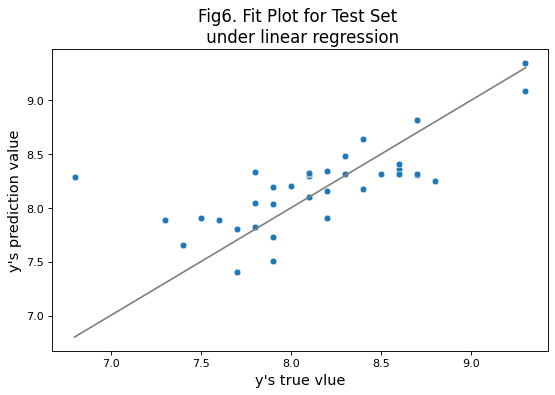

Linear train score: 0.5811, Train rmse: 0.341
Linear test score: 0.4976, Test rmse: 0.3631


In [ ]:
linear_reg = LinearRegression()

# Construct a pipeline in terms of linear regression
linear_pipe = Pipeline([
    ("make_dataframe", FunctionTransformer(DfTransformer,
                                          kw_args = {"column_names": 
                                                     list(X_train.columns)})),
    ("drop_duplicated", FunctionSampler(func=drop_duplicated, validate=False)),
    ("na_removal", FunctionSampler(func=drop_na, validate=False)),
    # Data and feature processing in terms of types of data
    ("separate_processing", ColumnTransformer([("num_pre", num_pre,[0,2,3,4,5]),
                                               ("cat_pre", cat_pre, [6]),
                                               ("date_pre", date_pre, [1])])), 
    ("model", linear_reg)
])

display(linear_pipe)

# Linear regression model fit
linear = linear_pipe.fit(X_train, y_train)

model_fit(linear, X_test, y_test, num=6, name='linear regression', plot=True);

rmse_train = np.sqrt(mean_squared_error(y_train, linear.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, linear.predict(X_test)))

# Print scores of linear model implemented on train set and test set
print(f'Linear train score: {linear.score(X_train, y_train).round(4)}, ' +
      f'Train rmse: {rmse_train.round(4)}')
print(f'Linear test score: {linear.score(X_test, y_test).round(4)}, ' +
      f'Test rmse: {rmse_test.round(4)}')

#### 3.3.2 Decision Tree

Decision trees form a tree with each split along a particular feature. Making a prediction based on the tree follow the record according to the split criteria until reaching a leaf node and take the average rating of those (Park & Ko, 2005).  There are several hyperparameters (like spliter, maximum depth, etc.) that have a massive impact on predictive ability, and we could not rule out any possibilities until we attempted many combinations of hyperparameters. However, various kind of decision trees receive the $R^2$ scores that are stable and concentrated on small interval around 0.18.
In terms of our choices of features, the predictive evaluation of decision trees fails to catch up with the linear regression method, even the basic one. As a consequence, we settled on the linear regression approach to fit and then validate.

#### 3.3.3 Multilayer Perceptron (MLP)

Neural networks have revolutionized the regression modeling field in the past decade. They are especially good at finding non-linear correlations between features in data compared to traditional models. This allows them to find more subtle relationships between features and patterns that less advanced algorithms would have found only through extensive feature engineering (Ghosh, De, & Pal, 2007).
By tuning the weights between nodes of different layers iteratively, neural networks are able to effectively represent the relationships between the data. Here we apply the most basic kind of neural network, the MLP, to model possible nonlinearity of different features and to exam its predictive performance. From our experiments, the values of RMSE and $R^2$ score in terms of various hyperparameters configured in MLP model are approximately identical (around 0.4 - 0.5) to the results obtained in Section 3.3.1 by linear regression. However, considering that the MLP is sensitive to the initial randomization of weight matrix and its computations are unstable, we will not choose the MLP as our baseline model. 

In summary, based on previous discussion, the predictive performance of basic linear regression is more acceptable in comparison with both other models. We thus choose linear regression as our baseline model.

### 3.4 Model Refinement

We attempt to refine our model in this section. At first, we consider the possible feature interactions in our linear regression model. Next, we choose Lasso regression to regularize our model and to select features with crucial influence on prediction and then validate the model to find the best hyperparameter. In the end, the final model with chosen features and parameter is employed and shows a better performance ($R^2$ score and RMSE) of predicting the IMDb ratings.

#### 3.4.1 Feature Interaction 

In the Section 3.3.1, we fit a linear model, considering the linear relationship between individual features and rating. In this section, we fit several polynomial models, by choosing different degrees and whether to include feature interaction terms, and comparing the results. We define an `interaction_reg_rmse` function to perform the fit for different degrees and different ways of combining features. We specify polynomial degrees from 1 to 5 and the results are displayed in the two DataFrames.

By comparing the data in the two output DataFrames, we can see that including the feature interaction term in the model improves the performance of the fit, as the RMSE is smaller for the relevant degree. In both DataFrames, the score corresponds to the $R^2$ score mentioned in Section 3.1. We can also observe that `test_score` becomes negative once the degree is greater than 1. Normally the $R^2$ score is a value between 0 and 1, and once it falls outside this range, we have chosen a model that is not suitable, or worse than a horizontal line. We can also notice this by looking at the values of score and rmse, when we choose a slightly larger degree, `train_score` reaches 1 for a 'perfect' model and `train_rmse` becomes very small, yet the corresponding `test_rmse` is much larger than this value, suggesting that the model is over-fitted at this stage. This result suggests that a degree of 1 is the most appropriate and gives us more confirmation of our choice of linear regression.

In [ ]:
def interaction_reg_rmse(X_train, y_train, X_test, y_test, degree, interact):
  '''
  Compare score and rmse of different datasets of polynomial 

  Input: 
    degree: degree of polynomial
    interact: boolean of whether include terms except interaction features
  Output:
    tuple of corresponding values
  '''
  poly_pipe = Pipeline([
  ("make_dataframe", FunctionTransformer(DfTransformer,
                                          kw_args = {"column_names": 
                                                     list(X_train.columns)})),
  ("drop_duplicated", FunctionSampler(func=drop_duplicated, validate=False)),
  ("na_removal", FunctionSampler(func=drop_na, validate=False)),
  ("separate_processing", ColumnTransformer([("num_pre", num_pre, [0,2,3,4,5]),
                                              ("cat_pre", cat_pre, [6]),
                                              ("date_pre", date_pre, [1])])),
  ("poly_feature", PolynomialFeatures(degree, interaction_only=interact)), 
  ("model", LinearRegression())])
  poly = poly_pipe.fit(X_train, y_train)
  
  # Score polynomial(interaction only or not) for train set and test set
  train_score = poly.score(X_train, y_train)
  test_score = poly.score(X_test, y_test)
  
  # Derive predictions for train set and test set
  pred_col = 'pred_d' + str(degree)
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  X_train_new[pred_col] = poly.predict(X_train)
  X_test_new[pred_col] = poly.predict(X_test)
  
  # Calculate rmse for train set and test set
  test_rmse = np.sqrt(mean_squared_error(y_test, X_test_new[pred_col]))
  train_rmse = np.sqrt(mean_squared_error(y_train, X_train_new[pred_col]))

  return (train_score, test_score, train_rmse, test_rmse)

In [ ]:
# Implement full polynomial expansion to features
# Get evaluations from degree 1 to 5
full_poly = pd.DataFrame(
    {'degree': range(1,6)}
).assign(
    train_score = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = False
        )[0] for i in x.degree],    
    test_score = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = False
        )[1] for i in x.degree],
    rmse_train = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = False
        )[2] for i in x.degree],
    rmse_test = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = False
        )[3] for i in x.degree]
)

print('Evaluation with full polynomial expansion terms from degree 1 to 5:')
display(full_poly)

# Implement sole interaction expansion to features
# Get evaluations from degree 1 to 5
only_interact = pd.DataFrame(
    {'degree': range(1,6)}
).assign(
    train_score = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = True
        )[0] for i in x.degree],    
    test_score = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = True
        )[1] for i in x.degree],
    rmse_train = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = True
        )[2] for i in x.degree],
    rmse_test = lambda x: [interaction_reg_rmse(
        X_train, y_train, X_test, y_test, degree=i, interact = True
        )[3] for i in x.degree]
)
print('\n')
print('Evaluation with only interaction expansion terms from degree 1 to 5:')
display(only_interact)

Evaluation with full polynomial expansion terms from degree 1 to 5:


,degree,train_score,test_score,rmse_train,rmse_test
0,1,0.581144,0.497641,3.410016e-01,0.363119
1,2,0.409685,-170.650889,4.048240e-01,6.712198
2,3,1.000000,-29.004722,1.400909e-14,2.806316
3,4,1.000000,-14.191671,4.582267e-14,1.996846
4,5,1.000000,-46.316329,3.626212e-13,3.524092




Evaluation with only interaction expansion terms from degree 1 to 5:


,degree,train_score,test_score,rmse_train,rmse_test
0,1,0.581144,0.497641,3.410016e-01,0.363119
1,2,0.910203,-7.967267,1.578902e-01,1.534164
2,3,1.000000,-11.675305,8.264596e-15,1.823984
3,4,1.000000,-4.930722,2.527429e-14,1.247658
4,5,1.000000,-7.618276,2.420389e-14,1.504014


#### 3.4.2 Lasso Regression

To yield better predictions and improve our model interpretation, in this section we use shrinkage methods involving fitting a linear regression model, in which the estimated coefficients are shrunken to zero relative to the least squares estimates. This regularization has the effect of reducing variables and also performing variable selection when some of the regression weights are exactly zero.

Considering that the dimension $d$ of our design matrix is large, and Ridge regression has a challenge in model interpretation in the setting where the number of independent variables, we apply the Lasso regression here to  regularize our linear regression model. Lasso regression shrinks the coefficient estimates towards zero, where the first-order penalty could force some of the coefficient estimates to be exactly equal to zero when the regularization parameter $\alpha$ is comparatively sufficiently large. Therefore, the Lasso performs variable selection that is similar with subset selection.

In [ ]:
# Set up parameter alpha
alphas = np.linspace(0.0001, 0.04, num=100)

# Initialize coefficients and rmses
betas = [] 
rmses = [] 

# Loop Lasso's parameter alpha
for a in alphas:
  # Construct pipeline for lasso regression with different alpha
  lasso_pipe = Pipeline(
      [("make_dataframe", FunctionTransformer(
          DfTransformer, kw_args = {"column_names": list(X_train.columns)})),
       ("drop_duplicated", FunctionSampler(
           func=drop_duplicated, validate=False)),
       ("na_removal", FunctionSampler(func=drop_na, validate=False)),
       ("separate_process", ColumnTransformer([("num_pre", num_pre,[0,2,3,4,5]),
                                               ("cat_pre", cat_pre, [6]),
                                               ("date_pre", date_pre, [1])])),
       ("model", Lasso(alpha=a))])
  lasso = lasso_pipe.fit(X_train, y_train)
    
  # Store coefficients and rmses
  betas.append((get_coefs(lasso)[1:]))
  rmses.append(model_fit(lasso, X_test, y_test))

# Convert coefficients and rmses into dataframe
res = pd.DataFrame(
    data = betas,
    columns = X_design.columns
).assign(
    alpha = alphas,
    rmse = rmses
).melt(
    id_vars = ('alpha', 'rmse')
)

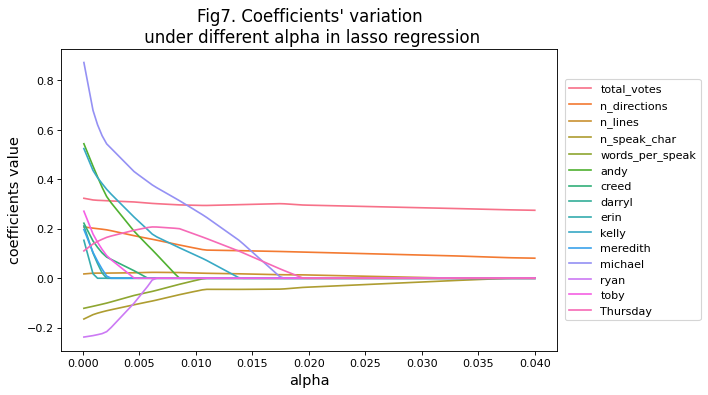

In [ ]:
# Lineplot the variation of coefficients when alpha changes
sns.lineplot(x='alpha', y='value', hue='variable', data=res)
plt.title(
    "Fig7. Coefficients' variation\n under different alpha in lasso regression",
    fontsize = 15)
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('alpha', fontsize=13)
plt.ylabel('coefficients value', fontsize=13)
plt.show()

#### 3.4.3 Cross Validation

This section we employ cross-validation to select a best value for regularization parameter $\alpha$ which is rely on random guesses that slowly converge to be meaningful. The model fitting may get a seemingly significant score with a specific guess when it is used on a particular training set, but it has a poor predictive performance when used on other training sets. To avoid this, most research uses $k$-fold cross validation, where the dataset is split into $k$ segments each time a model is called with new hyperparameters. Here we choose $k=5$. Each segment takes turns being the testing set to measure the predictive capability of the model trained on the rest of the data, which can essentially eliminate the possibility that the model is just making a guess rather than learning the trends in the training set. 

By applying 5-fold cross validation, we find the best estimator of regularization parameter $\alpha ≈ 0.0021.$ Using this parameter in Lasso regression, we obtain a improved model fitting test score from 0.4976 to 0.5108 and a better RMSE for test data decreased from 0.3631 to 0.3583.

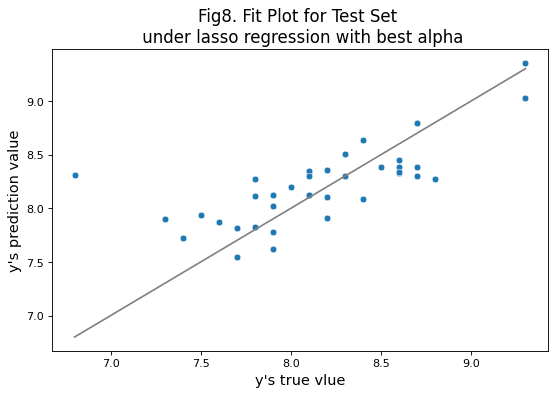

Best parameter: 0.0021
Train score: 0.5703, Train rmse: 0.3454
Test score: 0.5108, Test rmse: 0.3583


In [ ]:
# Construct pipeline for lasso without parameter
lasso_pipe = Pipeline(
    [("make_dataframe", FunctionTransformer(
        DfTransformer,kw_args = {"column_names": list(X_train.columns)})),
     ("drop_duplicated", FunctionSampler(func=drop_duplicated, validate=False)),
     ("na_removal", FunctionSampler(func=drop_na, validate=False)),
     ("separate_process", ColumnTransformer([("num_pre", num_pre, [0,2,3,4,5]),
                                             ("cat_pre", cat_pre, [6]),
                                             ("date_pre", date_pre, [1])])), 
     ("model", Lasso())
     ])
gs = GridSearchCV(lasso_pipe,
                  param_grid={'model__alpha': alphas},
                  cv=KFold(5, shuffle=True, random_state=42),
                  scoring="neg_root_mean_squared_error"
                  ).fit(X_train, y_train)

# Plot the prediction values against true values for test set
model_fit(gs.best_estimator_, X_test, y_test, num=8, 
          name='lasso regression with best alpha', plot=True)

# Derive best parameter through cross validation 
print(f'Best parameter: {gs.best_params_["model__alpha"].round(4)}')

# Evaluation on train set and test set using best alpha
train_rmse = np.sqrt(mean_squared_error(
    y_train, gs.best_estimator_.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(
    y_test, gs.best_estimator_.predict(X_test)))

print(f'Train score: {gs.best_estimator_.score(X_train, y_train).round(4)}, '+
      f'Train rmse: {train_rmse.round(4)}')
print(f'Test score: {gs.best_estimator_.score(X_test, y_test).round(4)}, ' +
      f'Test rmse: {test_rmse.round(4)}')

#### 3.4.4 Feature Development

In Section 3.4.2, we choose different regularization parameters $\alpha$ for the Lasso regression. In Fig.7, we can see that the penalty term causes the weights corresponding to some of the features (i.e. the coefficients of the linear regression) to fade to zero, so we use this for the selection of features. In this section we perform a new linear regression obtained at the optimal regularization parameter $\alpha$ ≈ 0.0021 and select variables with coefficients greater than zero. The reason for this choice is that we want to filter out the features that are positively correlated with the ratings. After building the new pipeline and fitting it, we can see that the test score rises from 0.4976 to 0.5236 after filtering out the above variables, which means that our model performs better after this selection of features.


,variable,value
0,michael,0.5435
1,kelly,0.3597
2,andy,0.3305
3,total_votes,0.3135
4,n_directions,0.1958
5,Thursday,0.1654
6,toby,0.0916
7,creed,0.0856
8,n_lines,0.0207
9,meredith,0.0087


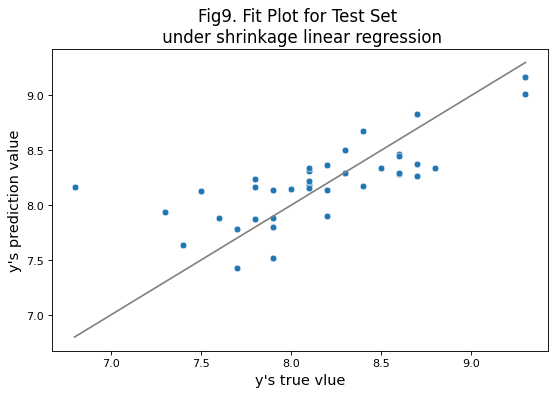

Train score: 0.5554, Train rmse: 0.3513
Test score: 0.5236, Test rmse: 0.3536


In [ ]:
# Derive coefficients under best alpha
best_coef = res[res.alpha==gs.best_params_['model__alpha']
                ][['variable','value']].round(4)
display(best_coef.sort_values(by='value', 
                              ascending=False).reset_index(drop=True))

# The features whose coefficients are bigger than 0
best_features = list(best_coef[best_coef.value > 0].variable)

# Construct a new pipeline of linear regression with additional exatract process
linear_reg = LinearRegression()
new_linear_pipe = Pipeline(
    [("make_dataframe", FunctionTransformer(
        DfTransformer, kw_args = {"column_names": list(X_train.columns)})),
    ("drop_duplicated", FunctionSampler(func=drop_duplicated, validate=False)),
    ("na_removal", FunctionSampler(func=drop_na, validate=False)),
    ("separate_processing", ColumnTransformer([("num_pre", num_pre,[0,2,3,4,5]),
                                              ("cat_pre", cat_pre, [6]),
                                              ("date_pre", date_pre, [1])])), 
    ("make_dataframe2", FunctionTransformer(
        DfTransformer, kw_args = {"column_names": list(X_design.columns)})),
    ("extract_best_features", FunctionTransformer(
        extract_columns, kw_args = {"features": best_features})),
    ("model", linear_reg)])

# Linear regression model fit
n = new_linear_pipe.fit(X_train, y_train)

model_fit(n, X_test, y_test, num=9, 
          name='shrinkage linear regression', plot=True);

# Print scores of linear model implemented on train set and test set
train_rmse = np.sqrt(mean_squared_error(y_train, n.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, n.predict(X_test)))

print(f'Train score: {n.score(X_train, y_train).round(4)}, ' +
      f'Train rmse: {train_rmse.round(4)}')
print(f'Test score: {n.score(X_test, y_test).round(4)}, ' +
      f'Test rmse: {test_rmse.round(4)}')

## 4. Conclusion

The creation of TV shows is an art and a science simultaneously. A successful predictive model can help TV production companies create more satisfying productions for audiences. Our model utilizes historical data to research and conclude the success of sitcoms. 

This study used supervised machine learning to predict ratings for the reunion special of *The Office*. The three supervised machine learning models evaluated were Linear Regression, Multilayer Perceptron (MLP) and Decision Tree. Out of the three models Linear Regression had the best performance not only in metric evaluations but also in its robustness. It was derived that the basic Linear Regression scoring at 0.4976 with RMSE approximately at 0.3631 on test set could still be potentially improved. Although, feature interaction terms' addition cannot reach our expectation, Lasso Regression and cross-validation provide us another refinement approach. Through finding the best parameter of Lasso Regularization, we simplify the features used in Linear Regression, which slightly enhanced the score to 0.5236. Ultimately we maintained nine features including number of ratings for episodes, number of lines containing a stage direction, number of spoken lines in episodes, air date on Thursday and main characters: Andy, Creed, Kelly, Michael and Tobby. We convince that our final model, shown in Fig.9, can be used to predict ratings to some extent. The predictions of ratings will fluctuate around the true value with error of roughly 0.3536 which leads to the reliability of our final model.

According to our final model, we suggest that characters Michael, Kelly, Andy, Creed and Tobby should be invited back to the reunion special, while executive is probably not supposed to invite Ryan back as his inverse impact on the rating. In addition, the writer tend to write more lines containing a stage direction. But the lines allocated to each characters should reduced. Beyond our model, a number of useful conclusions are also drawn from EDA part that *The Office* may continue the routine of airing on Thursdays. And Dwight, Jim, Pam, Kevin, Angela, Phyllis, Stanley and Oscar, the main characters who appeared nearly every episodes are recommended still starring at the TV show. Besides, Greg Daniels, Paul Feig, Ken Kwapis and Jeffrey Blitz, those who directed most episodes with high average ratings are likely to take charge of direction work and to deliver popular shows. Among all writers, Greg Daniels made outstanding performance both in the number of episodes and the average rating, is strongly encouraged to be responsible for the creation of the script.

Our model demonstrate understanding of the success of a TV show and how main characters can affect the IMDb ratings. Further analysis requires to concentrate on plenty of other factors, including advertising budget and internet broadcast in order to fully explain the variance of ratings of entire shows. However, due to statistical significance in main characters and total votes, we can still optimize them to improve the ratings.